In [1]:
import pandas as pd
import numpy as np
from scipy.stats import poisson 
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
tabla = pd.read_html('https://mexico.as.com/resultados/futbol/mls/clasificacion/')
jornadas = pd.read_html('https://mexico.as.com/resultados/futbol/mls/calendario/')

este=tabla[0]
oeste=tabla[1]

club1=este.Equipo.str.split("  ", n = 1, expand = True)
club2=oeste.Equipo.str.split("  ", n = 1, expand = True)
club_este=club1[1]
club_oeste=club2[1]
este['Equipo']=club_este
oeste['Equipo']=club_oeste

mls=pd.DataFrame()
mls = pd.concat([este, oeste])
jornadascompletas=2
local=jornadas[jornadascompletas]['Equipo local'].tolist()
visita=jornadas[jornadascompletas]['Equipo visitante'].tolist()
stats_este=este.describe()
stats_oeste=oeste.describe()
resultado=jornadas[jornadascompletas].Resultado.str.split("-", n = 1, expand = True).astype(int)
resultado.columns=['Local','Visita']
tamañojornada=len(local)
equipos_list=mls['Equipo'].tolist()
mls.index = range(0,len(equipos_list))
stats_mls=mls.describe()
equipos_list[14]='Austin FC'
equipos_list[15]='Los Angeles FC'

mls_av=pd.DataFrame()
mls_av['mean GF']=mls['GF'][:]/stats_mls['PJ'][1]
mls_av['mean GC']=mls['GC'][:]/stats_mls['PJ'][1]
mls_av['ataque']=mls_av['mean GF']/(stats_mls['GF'][1]/stats_mls['PJ'][1])
mls_av['defensa']=mls_av['mean GC']/(stats_mls['GC'][1]/stats_mls['PJ'][1])
stats_mls_av=mls_av.describe()

matrix_goles=pd.DataFrame()
ind=list(range(0,len(mls)))
for i in ind:
    matrix_goles[equipos_list[ind[i]]]=mls_av['ataque'][ind[i]]*mls_av['defensa'][:]*stats_mls_av['mean GF'][1]

matrix_goles.columns=equipos_list
matrix_goles.index=equipos_list

GFx_local=np.diag(matrix_goles[local].loc[visita])
GFx_visita=np.diag(matrix_goles[visita].loc[local])

k=[0,1,2,3,4,5]
P_home=pd.DataFrame()
P_away=pd.DataFrame()
mu=GFx_local
mu2=GFx_visita

for i in k:
    P_home[i]=poisson.pmf(k[i],mu)
    P_away[i]=poisson.pmf(k[i],mu2)

P_home.index=local
P_away.index=visita
P_home.index=local
P_away.index=visita

g=pd.DataFrame()
ind=list(range(0,tamañojornada))

for i in ind: 
    tabla=pd.DataFrame({local[i]:P_home.iloc[i].tolist(),visita[i]:P_away.iloc[i].tolist()})
    tabla.to_csv('tabla{}.csv'.format(i),index=False, sep=',')
    p=tabla.idxmax()
    g=pd.concat([g,p])

g=g[0]
Pgoles_home=g[local]
Pgoles_away=g[visita]
Pgoles_home.index=ind
Pgoles_away.index=ind

tabla=pd.DataFrame()
winlcl=pd.DataFrame()
winvis=pd.DataFrame()
e=pd.DataFrame()
ind=list(range(0,tamañojornada))

for i in ind:
    tabla=pd.read_csv('tabla{}.csv'.format(ind[i]))
    empate=pd.Series(tabla.iloc[0][0]*tabla.iloc[0][1]+tabla.iloc[1][0]*tabla.iloc[1][1]+tabla.iloc[2][0]*tabla.iloc[2][1]+tabla.iloc[3][0]*tabla.iloc[3][1]+tabla.iloc[4][0]*tabla.iloc[4][1]+tabla.iloc[5][0]*tabla.iloc[5][1])
    vis=pd.Series(tabla.iloc[0][0]*tabla.iloc[1][1]+tabla.iloc[0][0]*tabla.iloc[2][1]+tabla.iloc[0][0]*tabla.iloc[3][1]+tabla.iloc[0][0]*tabla.iloc[4][1]+tabla.iloc[0][0]*tabla.iloc[5][1]+tabla.iloc[1][0]*tabla.iloc[2][1]+tabla.iloc[1][0]*tabla.iloc[3][1]+tabla.iloc[1][0]*tabla.iloc[4][1]+tabla.iloc[1][0]*tabla.iloc[5][1]+tabla.iloc[2][0]*tabla.iloc[3][1]+tabla.iloc[2][0]*tabla.iloc[4][1]+tabla.iloc[2][0]*tabla.iloc[5][1]+tabla.iloc[3][0]*tabla.iloc[4][1]+tabla.iloc[3][0]*tabla.iloc[5][1]+tabla.iloc[4][0]*tabla.iloc[5][1])
    lcl=pd.Series(tabla.iloc[0][1]*tabla.iloc[1][0]+tabla.iloc[0][1]*tabla.iloc[2][0]+tabla.iloc[0][1]*tabla.iloc[3][0]+tabla.iloc[0][1]*tabla.iloc[4][0]+tabla.iloc[0][1]*tabla.iloc[5][0]+tabla.iloc[1][1]*tabla.iloc[2][0]+tabla.iloc[1][1]*tabla.iloc[3][0]+tabla.iloc[1][1]*tabla.iloc[4][0]+tabla.iloc[1][1]*tabla.iloc[5][0]+tabla.iloc[2][1]*tabla.iloc[3][0]+tabla.iloc[2][1]*tabla.iloc[4][0]+tabla.iloc[2][1]*tabla.iloc[5][0]+tabla.iloc[3][1]*tabla.iloc[4][0]+tabla.iloc[3][1]*tabla.iloc[5][0]+tabla.iloc[4][1]*tabla.iloc[5][0])
    e=pd.concat([e,empate])
    winvis=pd.concat([winvis,vis])
    winlcl=pd.concat([winlcl,lcl])

winvis.index=ind
winlcl.index=ind
e.index=ind
visita_gane=winvis
local_gane=winlcl
empate=e


In [3]:
pronosticoP=pd.DataFrame({'local':local,'P GF local':Pgoles_home,'P GF visita':Pgoles_away,'visita':visita})
pronosticoE=pd.DataFrame({'local':local,'E GF local':GFx_local,'E GF visita':GFx_visita,'visita':visita})

In [4]:
probabilidades=pd.DataFrame({'local':local, 'P ganar local':local_gane[0], 'P empate':empate[0], 'P ganar visita':visita_gane[0], 'visita':visita})
probabilidades

,local,P ganar local,P empate,P ganar visita,visita
0,New York City,0.593639,0.194980,0.183148,Montreal Impact
1,Columbus Crew,0.506774,0.249892,0.236678,Toronto FC
2,Inter Miami CF,0.141878,0.185825,0.644136,Los Angeles FC
3,Seattle Sounders,0.351105,0.275078,0.370673,Los Angeles Galaxy
4,Houston Dynamo,0.470486,0.250537,0.272259,Vancouver Whitecaps
5,Philadelphia Union,0.677326,0.180810,0.115712,San José Earthquakes
6,DC United,0.267273,0.251515,0.474709,Chicago Fire
7,New England Revolution,0.340045,0.254215,0.399646,Real Salt Lake
8,Orlando City,0.363779,0.240295,0.386178,FC Cincinnati
9,FC Dallas,0.433322,0.271057,0.292003,Nashville SC


In [5]:
pronosticoE

,local,E GF local,E GF visita,visita
0,New York City,2.243883,1.149306,Montreal Impact
1,Columbus Crew,1.600819,1.003362,Toronto FC
2,Inter Miami CF,0.936472,2.257565,Los Angeles FC
3,Seattle Sounders,1.190353,1.231399,Los Angeles Galaxy
4,Houston Dynamo,1.574975,1.131063,Vancouver Whitecaps
5,Philadelphia Union,2.222600,0.775325,San José Earthquakes
6,DC United,1.106739,1.568894,Chicago Fire
7,New England Revolution,1.313493,1.447274,Real Salt Lake
8,Orlando City,1.502003,1.555212,FC Cincinnati
9,FC Dallas,1.362140,1.064172,Nashville SC


In [6]:
pronosticoP

,local,P GF local,P GF visita,visita
0,New York City,2.0,1.0,Montreal Impact
1,Columbus Crew,1.0,1.0,Toronto FC
2,Inter Miami CF,0.0,2.0,Los Angeles FC
3,Seattle Sounders,1.0,1.0,Los Angeles Galaxy
4,Houston Dynamo,1.0,1.0,Vancouver Whitecaps
5,Philadelphia Union,2.0,0.0,San José Earthquakes
6,DC United,1.0,1.0,Chicago Fire
7,New England Revolution,1.0,1.0,Real Salt Lake
8,Orlando City,1.0,1.0,FC Cincinnati
9,FC Dallas,1.0,1.0,Nashville SC


In [7]:
jornadas[jornadascompletas]

,Equipo local,Resultado,Equipo visitante
0,New York City,4 - 1,Montreal Impact
1,Columbus Crew,2 - 1,Toronto FC
2,Inter Miami CF,0 - 2,Los Angeles FC
3,Seattle Sounders,3 - 2,Los Angeles Galaxy
4,Houston Dynamo,2 - 1,Vancouver Whitecaps
5,Philadelphia Union,2 - 0,San José Earthquakes
6,DC United,0 - 2,Chicago Fire
7,New England Revolution,2 - 3,Real Salt Lake
8,Orlando City,1 - 2,FC Cincinnati
9,FC Dallas,2 - 0,Nashville SC


In [8]:
ll=probabilidades[resultado['Local'].values>resultado['Visita'].values].local
l=probabilidades[probabilidades['P ganar local'].values>probabilidades['P ganar visita'].values].local
ll[ll.isin(l)].count()/l.count()

0.875

In [9]:
cc=probabilidades[resultado['Local'].values<resultado['Visita'].values].visita
c=probabilidades[probabilidades['P ganar local'].values<probabilidades['P ganar visita'].values].visita
cc[cc.isin(c)].count()/c.count()


0.6666666666666666

In [10]:
e=probabilidades['P empate']>probabilidades['P ganar local']
e2=probabilidades['P empate'][e]>probabilidades['P ganar visita'][e] 
if any(list(e2)) == True:
    print('si hay')

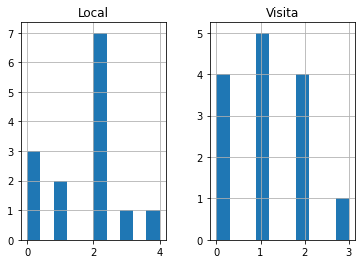

In [11]:
resultado.hist()
plt.show()